In [1]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb

import EquationsOfMotion as EOM
import LeapFrogIntegrator as LPI

%matplotlib inline

importing Jupyter notebook from EquationsOfMotion.ipynb
importing Jupyter notebook from LeapFrogIntegrator.ipynb


<string>:4: RuntimeWarning: divide by zero encountered in log
<string>:7: RuntimeWarning: divide by zero encountered in double_scalars
<string>:7: RuntimeWarning: invalid value encountered in double_scalars
<string>:10: RuntimeWarning: invalid value encountered in double_scalars
<string>:36: RuntimeWarning: invalid value encountered in true_divide


In [2]:
# ---------- Boris Integration ----------

def computeStep(rn,vn,dt,tn,Bz,f=EOM.f,a=EOM.a):
    tau = dt/2
    B = np.asarray([EOM.computeBx(rn[0],rn[1],a,f(tn)),EOM.computeBy(rn[0],rn[1],a,f(tn)),Bz])
    t = B*tau
    s = 2*t/(1+np.dot(t,t))
    vnew = vn + np.cross(vn + np.cross(vn,t),s)
    r = rn + vnew*dt
    tn += dt
    
    return r,vnew,B,tn
    
def integrateBoris(r0,v0,t0,dt,Bz,N,f=EOM.f,a=EOM.a):
    r,v,B = np.zeros([3,N+1]),np.zeros([3,N+1]),np.zeros([3,N+1])
    r[:,0],v[:,0],B[:,0] = r0,v0,np.asarray([EOM.computeBx(r0[0],r0[1],a,f(t0)),EOM.computeBy(r0[0],r0[1],a,f(t0)),Bz])
    t = t0
    for i in np.linspace(1,N,N,dtype='int'):
        r[:,i],v[:,i],B[:,i],t = computeStep(r[:,i-1],v[:,i-1],dt,t,Bz)    
    return r,v,B

def computeBNorm(B,N):
    normB = np.zeros([N+1])
    for i in np.linspace(0,N,N+1,dtype='int'):
        normB[i] = np.sqrt(np.dot(B[:,i],B[:,i]))
    return normB

In [3]:
# ---------- Integrating Multiple Trajectories ----------

def initICs(M,r0,dr,v0,dv,dimr='x',dimv='x'):
    return initRVICs(M,r0,dr,dimr),initRVICs(M,v0,dv,dimv)

def initRVICs(M,r0,dr,dim):
    _r0 = np.zeros([3,M+1])
    _r0[:,0] = r0
    if dim == 'x':
        for i in np.linspace(1,M,M,dtype='int'):
            _r0[:,i] = np.asarray([_r0[0,i-1]+dr,_r0[1,i-1],_r0[2,i-1]])
    elif dim == 'y':
        for i in np.linspace(1,M,M,dtype='int'):
            _r0[:,i] = np.asarray([_r0[0,i-1],_r0[1,i-1]+dr,_r0[2,i-1]])
    elif dim == 'z':
        for i in np.linspace(1,M,M,dtype='int'):
            _r0[:,i] = np.asarray([_r0[0,i-1],_r0[1,i-1],_r0[2,i-1]+dr])
    return _r0

def integrateSeries(_r0,_v0,t0,dt,Bz,N,M,f=EOM.f,a=EOM.a):
    fig,ax = None,None
    for i in np.linspace(0,M,M+1,dtype='int'):
        r0,v0 = _r0[:,i],_v0[:,i]
        r,v,B = integrateBoris(r0,v0,t0,dt,Bz,N,f=EOM.f,a=EOM.a)
        normB = computeBNorm(B,N)
        fig,ax = plot2D(r,v,normB,fig,ax)
        plot3D(r,v,normB)

In [4]:
# ---------- Plotting ----------

def computeAutoScaling(x,y): #Auto scaling for axes (This function was stolen from Pierre's intro to computational plasma notes: https://gourdain.pas.rochester.edu/index.php/introduction-to-plasma-physics)
    xc=(x.max()+x.min())/2.
    x_low=xc-(x.max()-x.min())/2.*1.1
    x_high=xc+(x.max()-x.min())/2.*1.1
    yc=(y.max()+y.min())/2.
    y_low=yc-(y.max()-y.min())/2.*1.1
    y_high=yc+(y.max()-y.min())/2.*1.1
    
    return x_low,x_high,y_low,y_high

def plot2D(r,v,normB,N,fig=None,ax=None):
    if (fig is None) and (ax is None):
        fig,ax = plt.subplots(2,2,figsize=(16,12))
    if N > 10000:
        size = 0.1
    else:
        size = 5
    
    J = EOM.J
    a = EOM.a
    
    ax[0,0].scatter(r[0,0],v[0,0],c='r',marker='*',s=55*size,label='Initial Position')
    c = ax[0,0].scatter(r[0,1:],v[0,1:],c=normB[1:],s=size)
    c = fig.colorbar(c,ax=ax[0,0])
    c.set_label('|B|',rotation=360)
    ax[0,0].set_xlabel('x')
    ax[0,0].set_ylabel('Px')
    ax[0,0].set_title(f'Px versus x (x phase space), J = {round(J,2)}')
    ax[0,0].grid()
    ax[0,0].legend()
    
    ax[0,1].scatter(r[1,0],v[1,0],c='r',marker='*',s=55*size,label='Initial Position')
    c = ax[0,1].scatter(r[1,1:],v[1,1:],c=normB[1:],s=size)
    c = fig.colorbar(c,ax=ax[0,1])
    c.set_label('|B|',rotation=360)
    ax[0,1].set_xlabel('y')
    ax[0,1].set_ylabel('Py')
    ax[0,1].set_title(f'Py versus y (y phase space), J = {round(J,2)}')
    ax[0,1].grid()
    ax[0,1].legend()
    
    ax[1,0].scatter(r[2,0],v[2,0],c='r',marker='*',s=55*size,label='Initial Position')
    c = ax[1,0].scatter(r[2,1:],v[2,1:],c=normB[1:],s=size)
    c = fig.colorbar(c,ax=ax[1,0])
    c.set_label('|B|',rotation=360)
    ax[1,0].set_xlabel('z')
    ax[1,0].set_ylabel('Pz')
    ax[1,0].set_title(f'Pz versus z (z phase space), J = {round(J,2)}')
    ax[1,0].grid()
    ax[1,0].legend()
  
    ax[1,1].scatter(r[0,0],r[1,0],c='r',marker='*',s=55*size,label='Initial Position')
    c = ax[1,1].scatter(r[0,1:],r[1,1:],c=normB[1:],s=size)
    c = fig.colorbar(c,ax=ax[1,1])
    c.set_label('|B|',rotation=360)
    ax[1,1].scatter(-a,0,marker='+',c='b',s=50)
    ax[1,1].scatter(a,0,marker='+',c='b',s=50)
    ax[1,1].set_xlabel('x')
    ax[1,1].set_ylabel('y')
    ax[1,1].set_title(f'Real Space Particle Trajectory, J = {round(J,2)}')
    ax[1,1].grid()
    ax[1,1].legend(loc=1)
    xmin,xmax,ymin,ymax = computeAutoScaling(r[0,1:],r[1,1:])
    ax[1,1].set_xlim(xmin=xmin,xmax=xmax)
    ax[1,1].set_ylim(ymin=ymin,ymax=ymax)
    return fig,ax
    
def plot3D(r,v,normB,fig=None,ax=None):
    fig = plt.figure(figsize=(16,12)) 
    size = 5
    J = EOM.J
    a = EOM.a
    
    ax = fig.add_subplot(1,2,1,projection='3d')
    ax.scatter(r[0,0],r[1,0],r[2,0],c='r',marker='*',s=15*size,label='Initial Position')
    ax.scatter(-a,0,0,marker='+',c='b',s=50)
    ax.scatter(a,0,0,marker='+',c='b',s=50)
    c = ax.scatter(r[0,1:],r[1,1:],r[2,1:],c=normB[1:],s=size)
    c = fig.colorbar(c,ax=ax,fraction=0.046,pad=0.1)
    c.set_label('|B|',rotation=360)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('3D Real Space Trajectory')
    ax.grid()
    ax.legend()
    margin = 1e-4
    ax.set_xlim(xmin=np.min(r[0,1:])-margin,xmax=np.max(r[0,1:])+margin)
    ax.set_ylim(ymin=np.min(r[1,1:])-margin,ymax=np.max(r[1,1:])+margin)
    ax.set_zlim(zmin=np.min(r[2,1:])-margin,zmax=np.max(r[2,1:])+margin)
    
    ax = fig.add_subplot(1,2,2,projection='3d')
    ax.scatter(v[0,0],v[1,0],v[2,0],c='r',marker='*',s=15*size,label='Initial Position')
    c = ax.scatter(v[0,1:],v[1,1:],v[2,1:],c=normB[1:],s=size)
    c = fig.colorbar(c,ax=ax,fraction=0.046,pad=0.04)
    c.set_label('|B|',rotation=360)
    ax.set_xlabel('Px')
    ax.set_ylabel('Py')
    ax.set_zlabel('Pz')
    ax.set_title('3D Momentum Space Trajectory')
    ax.grid()
    ax.legend()
    
def plotJ(t0,dt,N,normB):
    time = np.zeros([N+1])
    func = np.zeros([len(time)])
    time[0] = t0
    func[0] = EOM.f(t0)
    t = t0 + dt
    for i in np.linspace(1,len(time)-1,len(time),dtype='int'):
        func[i] = EOM.f(t)
        time[i] = t
        t += dt
    plt.figure(figsize=(12,10))
    plt.plot(time,func)
    plt.scatter(time,func,c=normB,s=5)
    plt.xlabel('Time (s)')
    plt.ylabel('Current')
    plt.title('Current Profile')
    plt.grid()
    
def plotE(p,t0,dt,N,normB):
    E = np.zeros([p.shape[1]])
    time = np.linspace(t0,t0+(N+1)*dt,N+1)
    for i in np.linspace(0,len(E)-1,len(E),dtype='int'):
        E[i] = np.sqrt( np.dot(p[:,i],p[:,i]) )
    var = str(np.var(E))
    length = len(var)
    plt.figure(figsize=(12,10))
    plt.plot(time,E,label=f'Variance of Energy = {var[0:6]+var[length-4:length]}')
    plt.scatter(time,E,c=normB)
    c = plt.colorbar()
    c.set_label('|B|',rotation=360)
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Total Energy')
    plt.title('Time Evolution of Total Energy')
    plt.legend()

In [5]:
dt = 1e-4 #Time step, 1e-3
t0 = 0 #Initial time
N = 250000 #Number of time steps

print(f'Time step: {dt}, Reconnection Time Scale: {EOM.tau}, Initial Time: {t0}, Final Time: {t0+(N+1)*dt}')

#r0 = np.asarray([-EOM.a,1e-3,0])
#v0 = np.asarray([3,-0.5,1])

#r0 = np.asarray([-EOM.a,1e-3,0])
#v0 = np.asarray([3e-1,-0.5,1e-3])

#r0 = np.asarray([0,2*EOM.a,0])
#v0 = np.asarray([3e-1,-0.5,1e-3])

#r0 = np.asarray([0,0,0])
#v0 = np.asarray([0.1,0.1,0])

#r0 = np.asarray([0,0,0])
#v0 = np.asarray([1e-4,0,0])

#r0 = np.asarray([-EOM.a/2,-EOM.a/2,0]) 
#v0 = np.asarray([1e-2,1e-2,0])

#r0 = np.asarray([0,0,0])
#v0 = np.asarray([0,0,1])

#r0 = np.asarray([0,0,0])
#v0 = np.asarray([1,1,1])

#r0 = np.asarray([-2*EOM.a,2*EOM.a,0])
#v0 = np.asarray([2,-2,2])

#r0 = np.asarray([0,2*EOM.a,0])
#v0 = np.asarray([0,-2,0])

r0 = np.asarray([EOM.a,1e-3,0])
v0 = np.asarray([3,-1,1])


Bz = 1 #0.003

Time step: 0.0001, Reconnection Time Scale: 1, Initial Time: 0, Final Time: 25.0001


In [6]:
r,v,B = integrateBoris(r0,v0,t0,dt,Bz,N)
normB = computeBNorm(B,N)

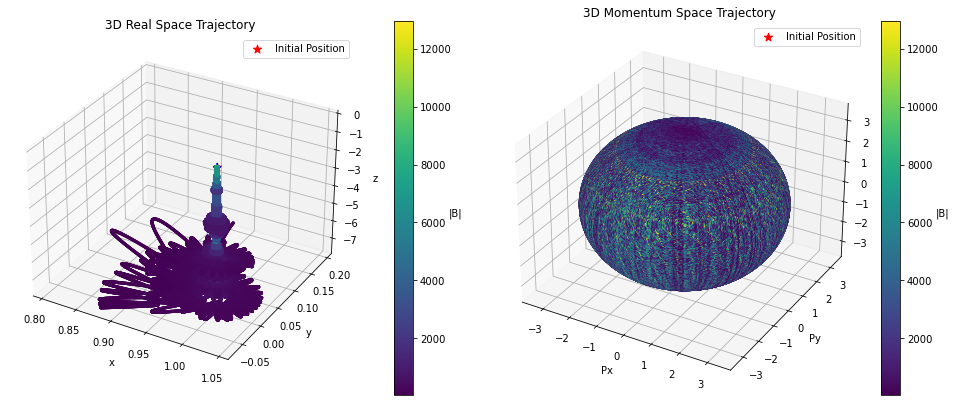

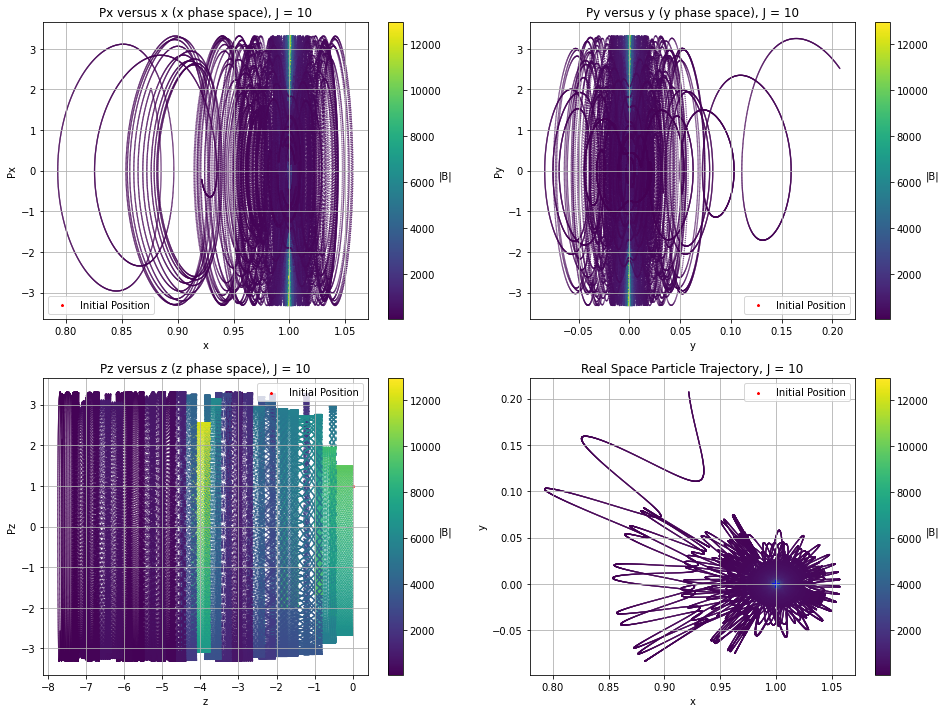

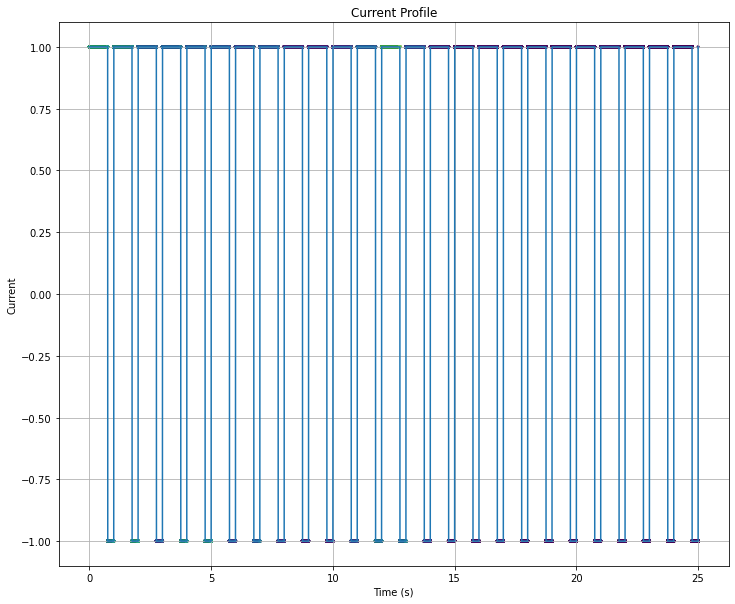

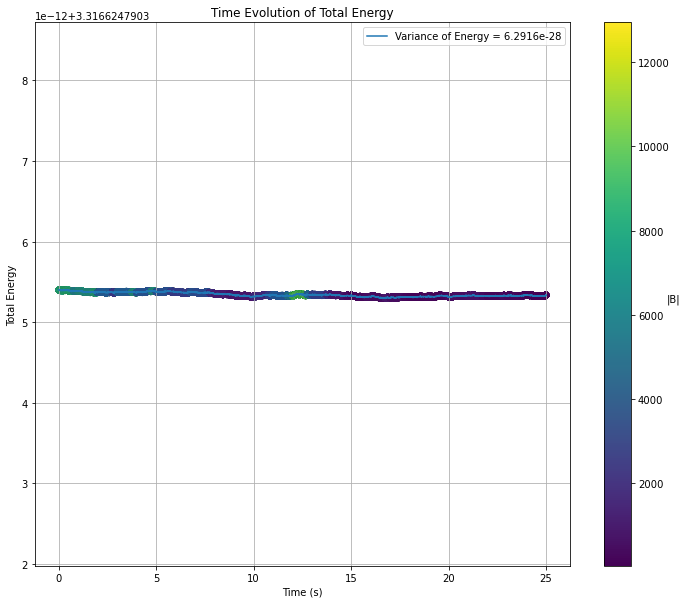

In [7]:
plot3D(r,v,normB)
plot2D(r,v,normB,N)
plotJ(t0,dt,N,normB)
plotE(v,t0,dt,N,normB)

In [8]:
'''M = 10 #Number of trajectories to integrate
r0 = np.asarray([-EOM.a/2,-EOM.a/2,0])
v0 = np.asarray([1e-2,1e-2,0])
dr = EOM.a/10
dv = 0

_r0,_v0 = initICs(M,r0,dr,v0,dv)''';

In [9]:
#integrateSeries(_r0,_v0,t0,dt,Bz,N,M)